Program ini dibuat menggunakan google colab sehingga input data dilakukan secara online memakai google drive. Berikut link folder untuk melihat kode program dan data https://drive.google.com/drive/folders/1LU_N9TdRxfyIAxHTCNr_axnxHPk5xJVb?usp=sharing

# Klasifikasi Kualitas Tanah untuk Jenis Tanaman dengan Menggunakan Neural Network

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gdown
import tensorflow as tf
from google.colab import files
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

# Install gdown if not installed
!pip install gdown

### Mendownload dan membaca data

In [ ]:
# ID file dari Google Drive
file_id = "12thM6X0-5OSOmgPpncMOOICrMbmJCsnc"
url = f"https://drive.google.com/uc?id={file_id}"

# Download train.csv
gdown.download(url, 'data.csv', quiet=False)

# Membaca dataset
dataset = pd.read_csv("data.csv")

Downloading...
From: https://drive.google.com/uc?id=12thM6X0-5OSOmgPpncMOOICrMbmJCsnc
To: /content/data.csv
100%|██████████| 145k/145k [00:00<00:00, 21.2MB/s]


### Melihat isi data secara ringkas

In [ ]:
dataset.head()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall,Crop
0,90,42,43,20.879744,82.002744,6.502985,202.935536,Rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,Rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,Rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,Rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,Rice


### Melihat jumlah jenis tanaman yang ada

In [ ]:
dataset['Crop'].unique()

array(['Rice', 'Maize', 'ChickPea', 'KidneyBeans', 'PigeonPeas',
       'MothBeans', 'MungBean', 'Blackgram', 'Lentil', 'Pomegranate',
       'Banana', 'Mango', 'Grapes', 'Watermelon', 'Muskmelon', 'Apple',
       'Orange', 'Papaya', 'Coconut', 'Cotton', 'Jute', 'Coffee'],
      dtype=object)

Terdapat 22 jenis tanaman sesuai yang ada di dataset

## **Preprocessing Data**

In [ ]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nitrogen     2200 non-null   int64  
 1   Phosphorus   2200 non-null   int64  
 2   Potassium    2200 non-null   int64  
 3   Temperature  2200 non-null   float64
 4   Humidity     2200 non-null   float64
 5   pH_Value     2200 non-null   float64
 6   Rainfall     2200 non-null   float64
 7   Crop         2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
None


### Melakukan pengecekan apakah terdapat missing value pada dataset

In [ ]:
dataset.isna().sum()

,0
Nitrogen,0
Phosphorus,0
Potassium,0
Temperature,0
Humidity,0
pH_Value,0
Rainfall,0
Crop,0


Dari hasil tabel diatas tidak ada misisng value

### Melakukan pengecekan apakah terdapat duplikasi data

In [ ]:
dataset.duplicated().sum()

0

Dari hasil diatas, dataset yang dipakai tidak memiliki data duplikat

Melakukan pengecekan apakah terdapat anomali data seperti outlier

In [ ]:
dataset.describe()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


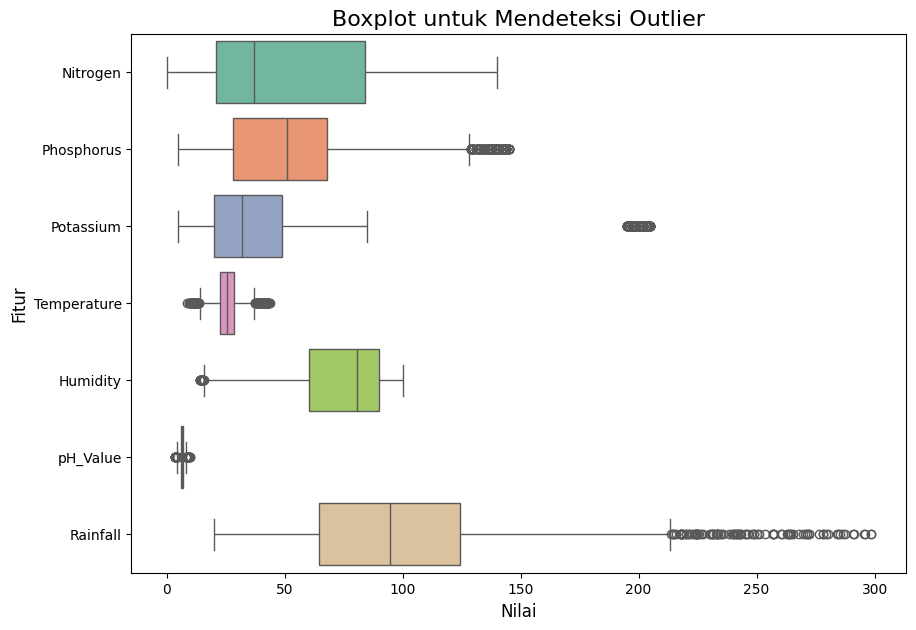

In [ ]:
# Membuat boxplot untuk setiap fitur untuk melihat outlier
df = pd.DataFrame(dataset)
plt.figure(figsize=(10, 7))
sns.boxplot(data=df, orient="h", palette="Set2")
plt.title("Boxplot untuk Mendeteksi Outlier", fontsize=16)
plt.xlabel("Nilai", fontsize=12)
plt.ylabel("Fitur", fontsize=12)
plt.show()

Dari hasil boxplot diatas terdapat data-data diluar rentang boxplot yang biasa dianggap outlier, namun hal ini tidak selalu ada kesalahan pada data. Melihat data yang banyak diluar rentang boxplot menandakan outlier seperti ini adalah bagian dari distribusi alami data.

### Melihat distribusi data pada setiap klasifikasi yang ada

In [ ]:
print("Crop Distribution:")
print(dataset['Crop'].value_counts())

Crop Distribution:
Crop
Rice           100
Maize          100
Jute           100
Cotton         100
Coconut        100
Papaya         100
Orange         100
Apple          100
Muskmelon      100
Watermelon     100
Grapes         100
Mango          100
Banana         100
Pomegranate    100
Lentil         100
Blackgram      100
MungBean       100
MothBeans      100
PigeonPeas     100
KidneyBeans    100
ChickPea       100
Coffee         100
Name: count, dtype: int64


Data pada setiap jenis klasifikasi tanaman sudah memiliki jumlah yang sama, yaitu 100 data. Hal ini dapat menghindari bias akibat model yang fokus dengan data mayoritas.

### Melakukan pemisahan data antara fitur-fitur (kolom 1-7) dan target (kolom 8)

In [ ]:
# Memisahkan fitur (x) and target (y)
x = dataset.drop(columns=["Crop"])
y = dataset["Crop"]

In [ ]:
x.head()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall
0,90,42,43,20.879744,82.002744,6.502985,202.935536
1,85,58,41,21.770462,80.319644,7.038096,226.655537
2,60,55,44,23.004459,82.320763,7.840207,263.964248
3,74,35,40,26.491096,80.158363,6.980401,242.864034
4,78,42,42,20.130175,81.604873,7.628473,262.717340


In [ ]:
y.head()

,Crop
0,Rice
1,Rice
2,Rice
3,Rice
4,Rice


Data fitur dan target sudah terpisah

### Melakukan normalisasi pada data fitur

In [ ]:
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)
x_normalized = pd.DataFrame(x_normalized, columns=x.columns)
x = x_normalized
print(x.head())

   Nitrogen  Phosphorus  Potassium  Temperature  Humidity  pH_Value  Rainfall
0  1.068797   -0.344551  -0.101688    -0.935587  0.472666  0.043302  1.810361
1  0.933329    0.140616  -0.141185    -0.759646  0.397051  0.734873  2.242058
2  0.255986    0.049647  -0.081939    -0.515898  0.486954  1.771510  2.921066
3  0.635298   -0.556811  -0.160933     0.172807  0.389805  0.660308  2.537048
4  0.743673   -0.344551  -0.121436    -1.083647  0.454792  1.497868  2.898373


Data fitur sudah dilakukan normalisasi menggunakan StandardScaler untuk mengubah data agar memiliki distribusi dengan rata-rata 0 dan standar deviasi 1. Ini membantu agar data memiliki skala yang seragam sehingga dapat digunakan lebih efektif dalam model. Rumus StandardScaler :

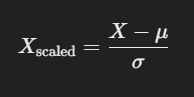

### Encode data target

In [ ]:
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(y)
print("Kategori yang telah di-encode:")
for i, category in enumerate(label_encoder.classes_):
    print(f"{category} --> {i}")

Kategori yang telah di-encode:
Apple --> 0
Banana --> 1
Blackgram --> 2
ChickPea --> 3
Coconut --> 4
Coffee --> 5
Cotton --> 6
Grapes --> 7
Jute --> 8
KidneyBeans --> 9
Lentil --> 10
Maize --> 11
Mango --> 12
MothBeans --> 13
MungBean --> 14
Muskmelon --> 15
Orange --> 16
Papaya --> 17
PigeonPeas --> 18
Pomegranate --> 19
Rice --> 20
Watermelon --> 21


Setiap jenis tanaman diinisiasi menggunakan angka. Encoding dilakukan menggunakan Label Encoder. Dengan demikian pada pembuatan model nantinya akan menggunakan loss function sparse categorical crossentropy.

In [ ]:
y = pd.Series(target)
y.head()

,0
0,20
1,20
2,20
3,20
4,20


Preprocessing sudah dilakukan dengan normalisasi serta pengecekan duplikasi data, missing value, anomali, dan lain-lainnya. Selanjutnya data akan dibagi menjadi data train (60%), validation (20%), dan test (20%).

In [ ]:
# Misalnya X adalah fitur (input) dan y adalah target (output) dari dataset Anda
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.40, random_state=42)

# Dari data yang tersisa (X_temp dan y_temp), kita bagi lagi menjadi 50% untuk validasi dan 50% untuk testing
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

## **Pembuatan Model Neural Network**

### Membuat model learning terlebih dahulu untuk mendapatkan evaluasi

In [ ]:
# Mendefinisikan model neural network menggunakan model Sequential
model_lr = models.Sequential([
    # Lapisan pertama dengan 256 unit dan fungsi aktivasi ReLU
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    # Dropout untuk mencegah overfitting
    Dropout(0.1),
    # Lapisan kedua dengan 128 unit dan fungsi aktivasi ReLU
    Dense(128, activation='relu'),
    # Batch Normalization untuk menormalkan output layer sebelumnya (untuk stabilitas dan percepatan pelatihan)
    BatchNormalization(),
    # Dropout lagi untuk regularisasi
    Dropout(0.1),
    # Lapisan ketiga dengan 64 unit dan fungsi aktivasi ReLU
    Dense(64, activation='relu'),
    # Dropout lagi untuk mencegah overfitting
    Dropout(0.1),
    # Lapisan keempat dengan 32 unit dan fungsi aktivasi ReLU
    Dense(32, activation='relu'),
    # Dropout lagi untuk regularisasi
    Dropout(0.1),
    # Lapisan terakhir dengan 22 unit dan fungsi aktivasi softmax untuk klasifikasi multi-kelas
    Dense(22, activation='softmax')
])

# Mengompilasi model dengan optimizer Adam dan fungsi loss sparse_categorical_crossentropy untuk masalah klasifikasi multi-kelas
model_lr.compile(optimizer=Adam(learning_rate=1e-7), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Membuat scheduler untuk learning rate yang akan menyesuaikan learning rate setiap epoch
lr_schedule = LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))

# Melatih model menggunakan data pelatihan dan validasi
history_lr = model_lr.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[lr_schedule])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.0531 - loss: 3.1956 - val_accuracy: 0.0500 - val_loss: 3.0800 - learning_rate: 1.0000e-07
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0670 - loss: 3.2555 - val_accuracy: 0.0364 - val_loss: 3.0750 - learning_rate: 1.1220e-07
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0415 - loss: 3.2510 - val_accuracy: 0.0318 - val_loss: 3.0703 - learning_rate: 1.2589e-07
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0565 - loss: 3.2415 - val_accuracy: 0.0341 - val_loss: 3.0665 - learning_rate: 1.4125e-07
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0742 - loss: 3.2060 - val_accuracy: 0.0250 - val_loss: 3.0634 - learning_rate: 1.5849e-07
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0665 - loss: 3.2616 - val_accuracy: 0.0227 - val_loss: 3.0615 - learning_rate: 1.7783e-07
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.

### Membuat grafik untuk menunjukkan hubungan antara learning rate dan loss

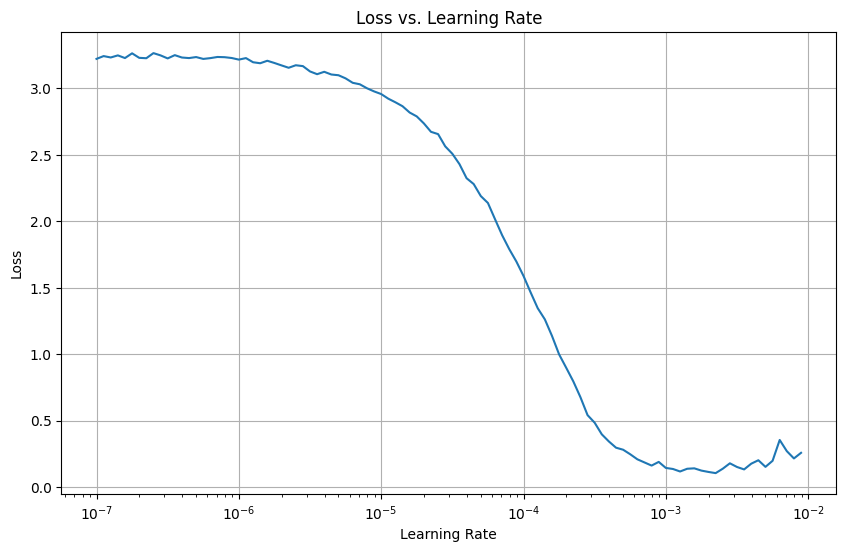

In [ ]:
lrs = 1e-7 * (10 ** (np.arange(100) / 20))
plt.figure(figsize=(10, 6))
plt.semilogx(lrs, history_lr.history["loss"])  # Log scale for learning rate on x-axis
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Loss vs. Learning Rate")
plt.grid(True)
plt.show()

Dari diagram diatas dapat dilihat bahwa learning rate yang memiliki loss lebih kecil adalah 0.001. Maka nilai itulah yang akan digunakan pada model sesungguhnya dibawah nanti.

### Menguji model learning pada data test

In [ ]:
test_loss, test_acc = model_lr.evaluate(X_test, y_test, verbose=2)

# Menampilkan hasil evaluasi
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

14/14 - 0s - 3ms/step - accuracy: 0.9455 - loss: 0.2137
Test accuracy: 0.9454545378684998
Test loss: 0.2136690616607666


### Membuat model sesungguhnya dari hasil evaluasi model learning diatas

In [ ]:
model = models.Sequential([
    # Lapisan pertama dengan 256 unit dan fungsi aktivasi ReLU
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    # Dropout untuk mencegah overfitting
    Dropout(0.1),
    # Lapisan kedua dengan 128 unit dan fungsi aktivasi ReLU
    Dense(128, activation='relu'),
    # Batch Normalization untuk menormalkan output layer sebelumnya (untuk stabilitas dan percepatan pelatihan)
    BatchNormalization(),
    # Dropout lagi untuk regularisasi
    Dropout(0.1),
    # Lapisan ketiga dengan 64 unit dan fungsi aktivasi ReLU
    Dense(64, activation='relu'),
    # Dropout lagi untuk mencegah overfitting
    Dropout(0.1),
    # Lapisan keempat dengan 32 unit dan fungsi aktivasi ReLU
    Dense(32, activation='relu'),
    # Dropout lagi untuk regularisasi
    Dropout(0.1),
    # Lapisan terakhir dengan 22 unit dan fungsi aktivasi softmax untuk klasifikasi multi-kelas
    Dense(22, activation='softmax')
])

# Mengompilasi model dengan optimizer Adam dan fungsi loss sparse_categorical_crossentropy untuk masalah klasifikasi multi-kelas
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Mengimplementasikan EarlyStopping untuk menghentikan pelatihan model lebih awal jika kinerja model pada data validasi tidak menunjukkan perbaikan lagi.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=1e-4,
    restore_best_weights=True
)

# Melatih model menggunakan data pelatihan dan validasi
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2258 - loss: 2.7187 - val_accuracy: 0.6000 - val_loss: 2.6368
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6735 - loss: 1.2889 - val_accuracy: 0.7932 - val_loss: 2.0782
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8064 - loss: 0.6960 - val_accuracy: 0.8500 - val_loss: 1.5505
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8605 - loss: 0.4399 - val_accuracy: 0.8955 - val_loss: 1.1330
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8778 - loss: 0.3689 - val_accuracy: 0.9568 - val_loss: 0.7360
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9227 - loss: 0.2487 - val_accuracy: 0.9545 - val_loss: 0.4536
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9479 - loss: 0.1926 - val_accuracy: 0.9727 - val_loss: 0.2739
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9572 - loss: 0.1558 - val_accuracy: 0.9727 - val_loss: 0.

### Membuat visualisasi performa model neural network

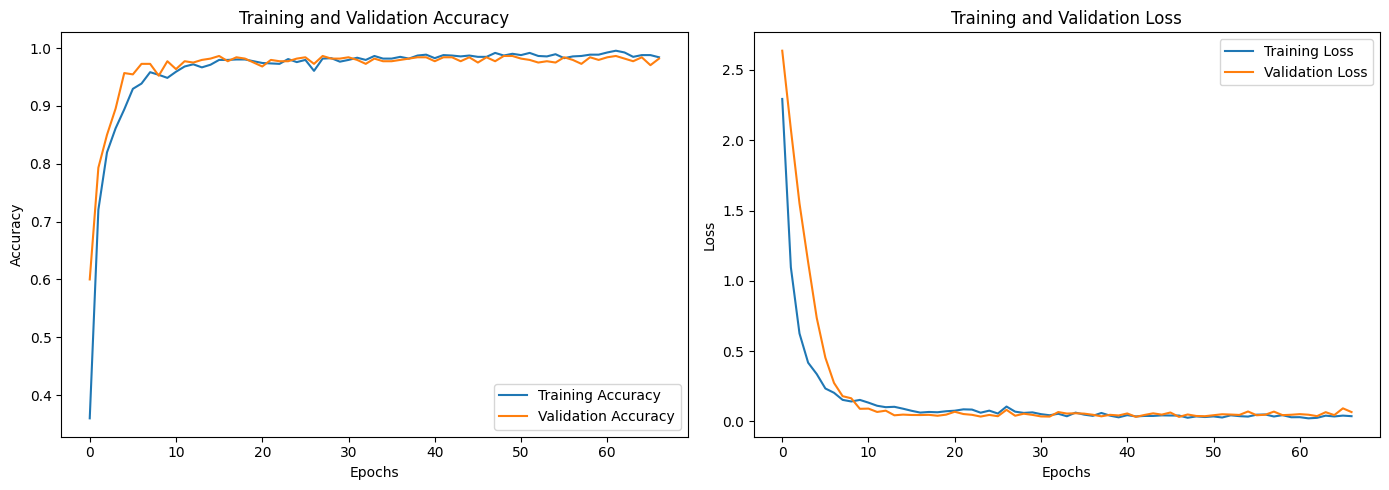

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.set_title('Training and Validation Accuracy')
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.set_title('Training and Validation Loss')
plt.tight_layout()
plt.show()

Model memiliki performa baik karena akurasi training dan validasi tinggi serta konsisten. Tidak ada tanda-tanda overfitting atau underfitting dari model yang dibuat. Loss pada data training dan validasi juga menurun secara konsisten, menunjukkan pelatihan berjalan lancar dan model tidak mengalami masalah optimasi.

### Menguji model sesungguhnya pada data test

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

# Menampilkan hasil evaluasi
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

14/14 - 0s - 3ms/step - accuracy: 0.9795 - loss: 0.0881
Test accuracy: 0.9795454740524292
Test loss: 0.08805668354034424


Model sesungguhnya (Hasil 2) memberikan hasil yang lebih baik dibandingkan model learning (Hasil 1). Model sesungguhnya tidak hanya lebih akurat, tetapi juga lebih efisien dalam meminimalkan kesalahan prediksi. Ini menunjukkan bahwa model sesungguhnya lebih baik dalam menggeneralisasi data baru, sedangkan model learning mungkin terpengaruh oleh faktor seperti overfitting atau kesalahan dalam pengaturan pelatihan.

Mencoba dengan 1 data test

In [ ]:
input = np.array([[44, 57, 53, 42.30495821, 90.51431779, 6.93172108, 74.876786]])

In [ ]:
input = scaler.transform(input)
prediksi = model.predict(input)
predicted_class = np.argmax(prediksi, axis=1)
decoded_class = label_encoder.inverse_transform(predicted_class)
print(f"Prediksi kelas untuk data baru: {decoded_class}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Prediksi kelas untuk data baru: ['Papaya']


Hasil yang diperoleh adalah Papaya